In [24]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from scipy.stats import ttest_ind, invgamma, norm
import pymc3 as pm

# Group comparison
in this chapter we are discussing how to compare groups of independent measurements.  As an example, we are going to look at a sample of 10th grade math scores from two different public U.S. high schools.  Thirty-one students from school 1 and 28 students from school 2 were randomly selected.  Both schools have a total enrollment of around 500 10th graders each, and both are in urban neighborhoods.

In [25]:
school1scores=np.array([52.11, 57.65, 66.44, 44.68, 40.57, 35.04, 50.71, 66.17, 39.43, 
46.17, 58.76, 47.97, 39.18, 64.63, 69.38, 32.38, 29.98, 59.32, 
43.04, 57.83, 46.07, 47.74, 48.66, 40.8, 66.32, 53.7, 52.42, 
71.38, 59.66, 47.52, 39.51])
school2scores=np.array([52.87, 50.03, 41.51, 37.42, 64.42, 45.44, 46.06, 46.37, 46.66, 
29.01, 35.69, 49.16, 55.9, 45.84, 35.44, 43.21, 48.36, 74.14, 
46.76, 36.97, 43.84, 43.24, 56.9, 47.64, 38.84, 42.96, 41.58, 
45.96])

(array([ 1.,  4.,  3., 11.,  4.,  2.,  1.,  1.,  0.,  1.]),
 array([29.01 , 33.523, 38.036, 42.549, 47.062, 51.575, 56.088, 60.601,
        65.114, 69.627, 74.14 ]),
 <a list of 10 Patch objects>)

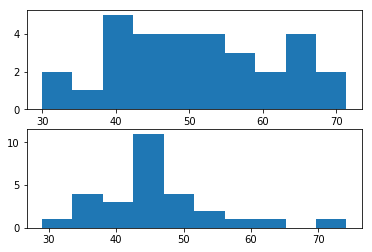

In [26]:
plt.figure()
plt.subplot(2,1,1)
plt.hist(school1scores)
plt.subplot(2,1,2)
plt.hist(school2scores)

{'whiskers': [<matplotlib.lines.Line2D at 0x1c1fa67470>,
 'caps': [<matplotlib.lines.Line2D at 0x1c1fa67d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c1fa67320>,
 'medians': [<matplotlib.lines.Line2D at 0x1c1fa6d5c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c1fa6d9e8>,
 'means': []}

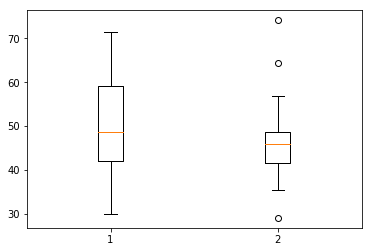

In [27]:
data=[school1scores,school2scores]
plt.figure()
plt.boxplot(data)

In [28]:
s1mean=school1scores.mean()
s1std=school1scores.std(ddof=1)
s2mean=school2scores.mean()
s2std=school2scores.std(ddof=1)
print("School 1 mean {}, std {}".format(s1mean,s1std))
print("School 2 mean {}, std {}".format(s2mean,s2std))

School 1 mean 50.81354838709678, std 11.250249641196737
School 2 mean 46.15071428571428, std 9.052143567940313


In [29]:
result=ttest_ind(school1scores,school2scores)
print(result)

Ttest_indResult(statistic=1.7418211969266815, pvalue=0.08693402825485128)


According to "standard" statistics the difference between the two schools seems not significant.  Let us see whether we can learn a little more by using a Bayesian approach.

We start by expressing the scores of the two schools as draws from two distributions:

$$Y_{i,1} = \mu + \delta + N(0,\sigma^{2})$$
$$Y_{i,2} = \mu -\delta + N(0,\sigma^{2})$$

here we assume that the standard deviation for both schools is the same.  We chose priors for these parameters to be
$$P(\mu,\delta,\sigma^{2}) = P(\mu)P(\delta)P(\sigma^{2})$$
$$P(\mu) = N(\mu_{0},\gamma_{0})$$
$$P(\delta) = N(\delta_{0},\tau_{0})$$
$$P(\sigma^{2}) = inverse-gamma(\nu_{0}/2,\nu_{0}\sigma_{0}/2)$$

As parameters we chose the following:

1) $\mu_0$ should be $50$ since the average test score nationwide has a mean of $50$.

2) a reasonable $\sigma_{0}^{2}=10^{2}=100$

3) $\gamma_{0}^{2}=25^{2}=625$ and $\nu_{0}=1$

4) $\delta_{0}=0$ and $\tau_{0}^{2}=25^{2}=625$

In [30]:
nu0=1.0
gamma0=25.0
mu0=50.0
sigma0=10.0
delta0=0.0
tau0=25.0

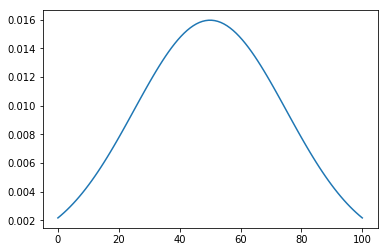

In [31]:
# prior for mu
mu = np.linspace(0,100,100)
pmu = norm.pdf(mu,loc=mu0,scale=25)
plt.plot(mu,pmu)

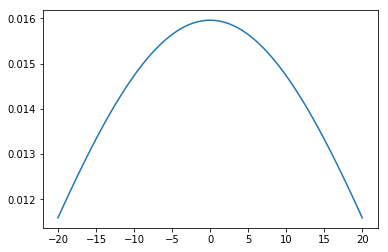

In [32]:
# prior for delta
d = np.linspace(-20,20,100)
pd = norm.pdf(d,loc=0,scale=25)
plt.plot(d,pd)

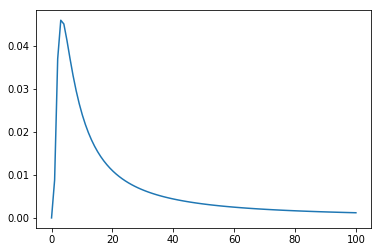

In [33]:
# prior for sigma^2
s = np.linspace(0,100,100)
ps = invgamma.pdf(s,a=nu0/2,scale=nu0*sigma0/2)
plt.plot(s,ps)

In [34]:
with pm.Model() as bayesianTwoGroups:
    sigmaSquare=pm.InverseGamma('sigmaSquare',nu0/2.0,nu0*sigma0**2/2.0)
    mu=pm.Normal('mu',mu=mu0,tau=1/gamma0**2)
    delta=pm.Normal('delta',mu=delta0,tau=1/tau0**2)
    
    s1=pm.Normal('s1',mu=mu+delta,tau=1/sigmaSquare,observed=school1scores)
    s2=pm.Normal('s2',mu=mu-delta,tau=1/sigmaSquare,observed=school2scores)

In [35]:
with bayesianTwoGroups:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, mu, sigmaSquare]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:02<00:00, 7465.43draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c20e82518>,
      dtype=object)

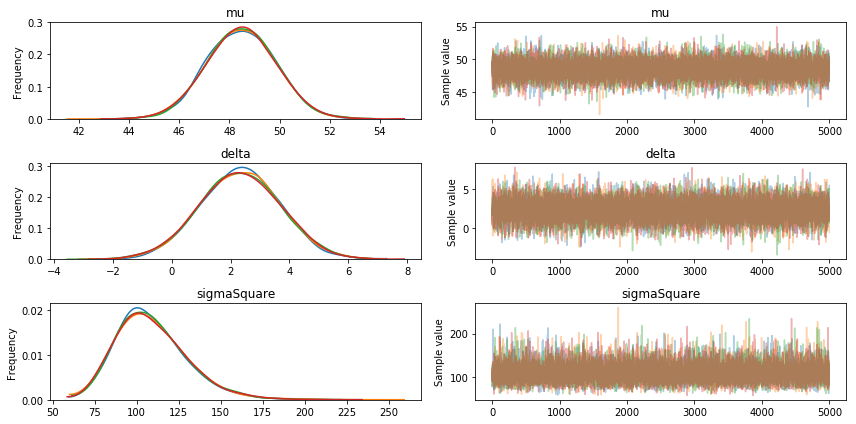

In [36]:
pm.traceplot(trace)

In [37]:
pm.summary(trace)

/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,48.479471,1.356084,0.009663,45.771486,51.038124,26036.085986,0.999958
delta,2.323918,1.358778,0.008204,-0.339123,4.968498,26794.426658,0.999960
sigmaSquare,109.202707,21.012687,0.121024,71.358376,150.273727,23129.405796,0.999941


In [38]:
# get the delta trace (sample) from the MCMC simulation
delta_trace=np.array(trace['delta'])

In [39]:
# calculate the probability that the difference between schools is greater than zero
delta_trace_greater_zero=delta_trace[delta_trace>0]
print(delta_trace_greater_zero.size/delta_trace.size)

0.9562
